In [1]:
# commented out, deprecated parameters to specify dataset paths:
# data_path = '../example-data'
# # data_path = 'gs://elife-public-data/sciencebeam/datasets'
# dataset_relative_paths = ['pmc-sample-1943-cc-by-subset']
# dataset_suffixes = []
# output_path_suffix = '-results'
# tool_names = ['grobid-tei', 'cermine']

_base_dataset_results_path = '../example-data/pmc-sample-1943-cc-by-subset-results'
dataset_names = ['pmc-sample-1943-cc-by-subset']
tool_names = ['grobid-tei', 'cermine']
evaluation_results_paths = [
    '%s/%s/evaluation-results' % (_base_dataset_results_path, tool)
    for tool in tool_names
]


affiliation_field_names = ['affiliation_strings', 'affiliation_institution']
first_reference_field_names = [
    'first_reference_text', 'first_reference_fields',
    'first_reference_author_surnames', 'first_reference_author_given_names',
    'first_reference_author_full_names',
    'first_reference_title', 'first_reference_year',
    'first_reference_source', 'first_reference_volume', 'first_reference_fpage',
    'first_reference_lpage',
]
reference_field_names = [
    'reference_text',
    'reference_fields',
    'reference_author_surnames', 'reference_author_given_names', 'reference_author_full_names',
    'reference_title', 'reference_year',
    'reference_source', 'reference_volume', 'reference_fpage', 'reference_lpage'
]
table_field_names = ['tables', 'table_strings', 'table_labels', 'table_captions', 'table_label_captions']
figure_field_names = ['figure_labels', 'figure_captions', 'figure_label_captions']
body_field_names = ['section_titles']
field_set_field_names = [
    ('header body', (
        [
            'title',
            'first_author_full_name', 'author_full_names',
            'abstract'
        ] + body_field_names + affiliation_field_names
    )),
    ('first reference', first_reference_field_names),
    ('reference', reference_field_names),
    ('tables and figures', table_field_names + figure_field_names)
]
evaluation_methods = ['levenshtein', 'exact']
summary_filename = 'summary-00000-of-00001.csv'
show_tables = False

# Conversion Results Summary

In [2]:
# This Conversion Results Notebook by default use the very small example dataset
# You may pass in other parameters, e.g.:
#   $papermill conversion-results-tools.ipynb conversion-results-tools-configured.ipynb -p data_path '/my/other/data/path'

In [3]:
%matplotlib inline

In [4]:
import matplotlib
matplotlib.style.use('ggplot')

In [5]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import time
import os
import subprocess
import re
from collections import OrderedDict
from typing import List

import pandas as pd
import matplotlib.pyplot as plt
from markdown import markdown
from IPython.display import display, HTML

warnings.filterwarnings('default')

In [6]:
def parse_list(s):
    if isinstance(s, list):
        return s
    return [x.strip() for x in s.split(',') if x.strip()]


def parse_list_dict(s):
    if isinstance(s, dict):
        return s
    return {
        key: value.split('|')
        for item in parse_list(dataset_suffixes)
        for key, value in [item.split(':')]
    }


tool_names = parse_list(tool_names)
# field_names = parse_list(field_names)
evaluation_methods = parse_list(evaluation_methods)

try:
    # parse legacy parameters
    dataset_relative_paths = parse_list(dataset_relative_paths)
    dataset_suffixes = parse_list_dict(dataset_suffixes)
except NameError:
    dataset_names = parse_list(dataset_names)
    evaluation_results_paths = parse_list(evaluation_results_paths)

In [7]:
try:
    # parse legacy parameters
    evaluation_results_descriptors = [
        {
            'dataset_name': '%s%s' % (dataset_relative_path, dataset_suffix),
            'tool': tool,
            'evaluation_results_path': os.path.join(
                data_path,
                '%s%s/%s/evaluation-results/%s' % (
                    dataset_relative_path,
                    output_path_suffix,
                    tool,
                    dataset_suffix
                )
            )
        }
        for dataset_relative_path in dataset_relative_paths
        for dataset_suffix in dataset_suffixes.get(dataset_relative_path, [''])
        for tool in tool_names
    ]
except NameError:
    if len(dataset_names) == 1:
        dataset_names = dataset_names * len(evaluation_results_paths)
    assert len(dataset_names) == len(evaluation_results_paths)
    assert len(tool_names) == len(evaluation_results_paths)
    evaluation_results_descriptors = [
        {
            'dataset_name': dataset_name,
            'tool': tool,
            'evaluation_results_path': evaluation_results_path
        }
        for dataset_name, tool, evaluation_results_path in zip(
            dataset_names, tool_names, evaluation_results_paths
        )
    ]


all_result_paths = [
    (
        '%s %s' % (evaluation_results_descriptor['dataset_name'], evaluation_results_descriptor['tool']),
        evaluation_results_descriptor['evaluation_results_path']
    )
    for evaluation_results_descriptor in evaluation_results_descriptors
]


distinct_dataset_names = list(OrderedDict.fromkeys(
    evaluation_results_descriptor['dataset_name']
    for evaluation_results_descriptor in evaluation_results_descriptors
))

In [8]:
all_result_names = [name for name, _ in all_result_paths]

In [9]:
def printmd(s):
    try:
        s = s.decode('unicode_escape')
    except AttributeError:
        pass
    display(HTML(markdown(s)))

In [10]:
def retrieve_local_copy_if_remote(file_url):
    if file_url.startswith('gs://'):
        local_filename = os.path.join('../.temp', os.path.basename(file_url))
        subprocess.check_output('gsutil cp -P "%s" "%s"' % (file_url, local_filename), shell=True)
        # would be nice if gsutil did actually copy the creation time, let's do it here in a hacky way
        timestamp_match = re.search(r'\s(\d{4}-[^ ]+)\s', subprocess.check_output('gsutil ls -l "%s"' % file_url, shell=True).decode('utf-8'))
        file_time = time.mktime(datetime.strptime(timestamp_match.group(1), "%Y-%m-%dT%H:%M:%SZ").timetuple())
        os.utime(local_filename, (file_time, file_time))
        return local_filename

    return file_url

def load_result_map(all_result_paths, filename):
    df_map = {}
    for name, result_path in all_result_paths:
        full_filename = retrieve_local_copy_if_remote(os.path.join(result_path, filename))
        printmd('**Timestamp:** %s (%s)' % (datetime.fromtimestamp(os.path.getmtime(full_filename)), name))
        df = pd.read_csv(full_filename)
        df['field_name_scoring_type'] = df['field_name'].str.cat(
            df['scoring_type'], sep=':'
        )
        df_map[name] = df
        if show_tables:
            display(df_map[name].head(3))
    return df_map

printmd('## Summary Files')
summary_df_map = load_result_map(all_result_paths, summary_filename)

In [11]:
printmd('### Evaluation File States')
printmd('**Evaluation methods:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['evaluation_method']
))))
printmd('**Field names:** %s' % ', '.join(sorted(set(
    summary_df_map[all_result_names[0]]['field_name'].dropna()
))))

In [12]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
title:string,0.700000,1.000000,title,string,levenshtein
first_author_full_name:string,0.600000,0.500000,first_author_full_name,string,levenshtein
author_full_names:partial_set,0.573770,0.527473,author_full_names,partial_set,levenshtein
abstract:string,0.588235,0.500000,abstract,string,levenshtein
section_titles:partial_list,0.493506,0.229885,section_titles,partial_list,levenshtein
section_titles:partial_set,0.794702,0.639053,section_titles,partial_set,levenshtein
section_titles:partial_ulist,0.792208,0.632184,section_titles,partial_ulist,levenshtein
affiliation_strings:partial_set,0.425532,0.641509,affiliation_strings,partial_set,levenshtein
affiliation_institution:partial_set,0.341463,0.226415,affiliation_institution,partial_set,levenshtein
mean,0.589935,0.544058,,,


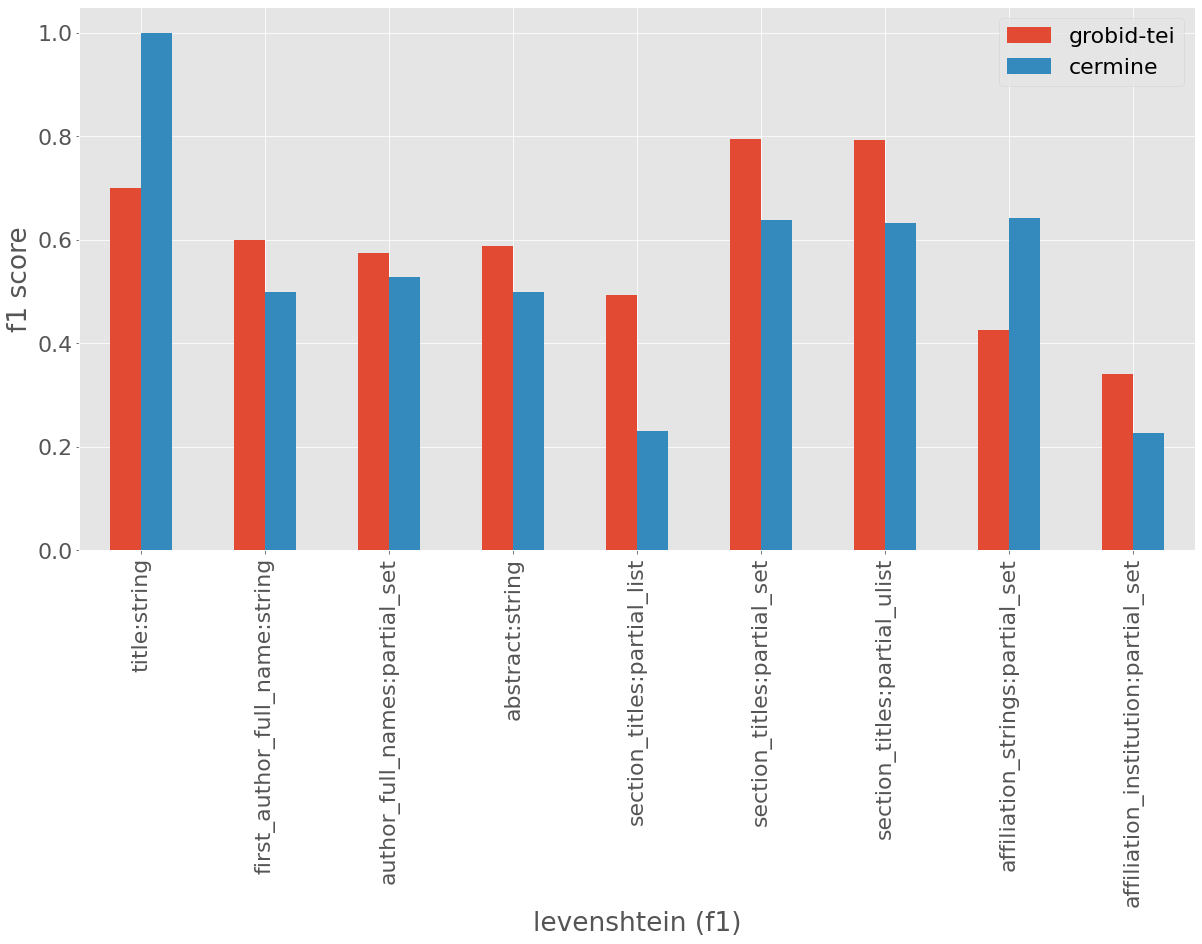

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
first_reference_text:string,0.000000,1.000000,first_reference_text,string,levenshtein
first_reference_fields:list,0.700000,0.900000,first_reference_fields,list,levenshtein
first_reference_author_surnames:list,0.600000,0.700000,first_reference_author_surnames,list,levenshtein
first_reference_author_given_names:list,0.000000,0.200000,first_reference_author_given_names,list,levenshtein
first_reference_author_full_names:list,0.400000,0.600000,first_reference_author_full_names,list,levenshtein
first_reference_title:string,0.769231,1.000000,first_reference_title,string,levenshtein
first_reference_year:string,0.500000,0.700000,first_reference_year,string,levenshtein
first_reference_source:string,0.421053,0.600000,first_reference_source,string,levenshtein
first_reference_volume:string,0.555556,0.750000,first_reference_volume,string,levenshtein
first_reference_fpage:string,0.555556,0.750000,first_reference_fpage,string,levenshtein


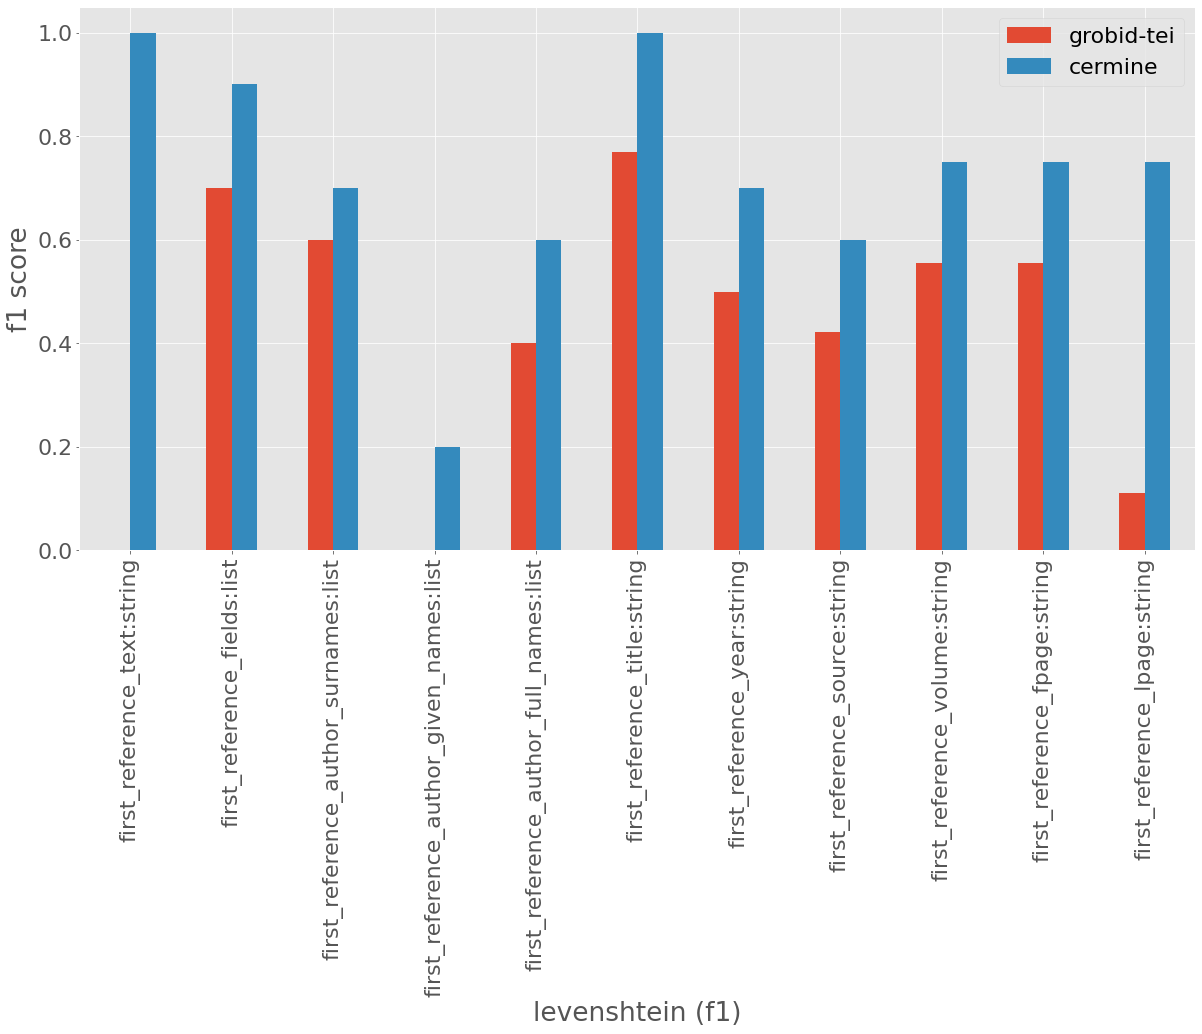

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
reference_text:partial_list,0.000000,0.946779,reference_text,partial_list,levenshtein
reference_text:partial_set,0.000000,0.946779,reference_text,partial_set,levenshtein
reference_text:partial_ulist,0.000000,0.946779,reference_text,partial_ulist,levenshtein
reference_fields:partial_list,0.623037,0.935574,reference_fields,partial_list,levenshtein
reference_fields:partial_ulist,0.821990,0.935574,reference_fields,partial_ulist,levenshtein
reference_author_surnames:partial_list,0.491713,0.645892,reference_author_surnames,partial_list,levenshtein
reference_author_surnames:partial_set,0.643678,0.637681,reference_author_surnames,partial_set,levenshtein
reference_author_surnames:partial_ulist,0.642458,0.645892,reference_author_surnames,partial_ulist,levenshtein
reference_author_given_names:partial_list,0.049587,0.236311,reference_author_given_names,partial_list,levenshtein
reference_author_given_names:partial_set,0.092486,0.242604,reference_author_given_names,partial_set,levenshtein


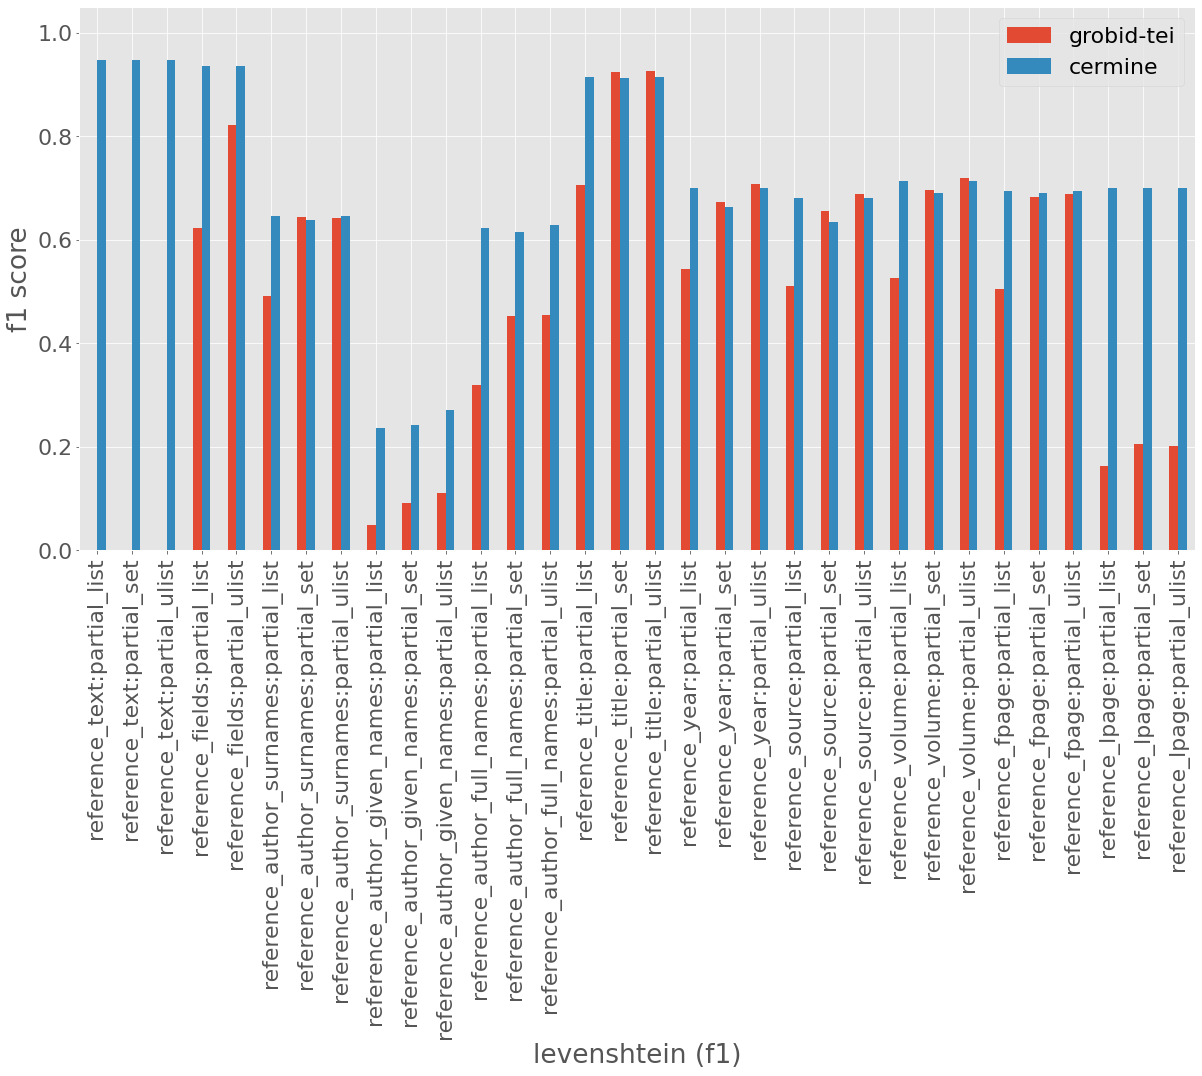

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
tables:partial_table,0.000000,0.000000,tables,partial_table,levenshtein
table_strings:partial_list,0.210526,0.000000,table_strings,partial_list,levenshtein
table_labels:partial_list,0.424242,0.000000,table_labels,partial_list,levenshtein
table_labels:partial_set,0.500000,0.000000,table_labels,partial_set,levenshtein
table_captions:partial_list,0.216216,0.000000,table_captions,partial_list,levenshtein
table_captions:partial_set,0.432432,0.000000,table_captions,partial_set,levenshtein
table_label_captions:partial_list,0.205128,0.000000,table_label_captions,partial_list,levenshtein
table_label_captions:partial_set,0.410256,0.000000,table_label_captions,partial_set,levenshtein
figure_labels:partial_list,0.340426,0.000000,figure_labels,partial_list,levenshtein
figure_labels:partial_set,0.468085,0.000000,figure_labels,partial_set,levenshtein


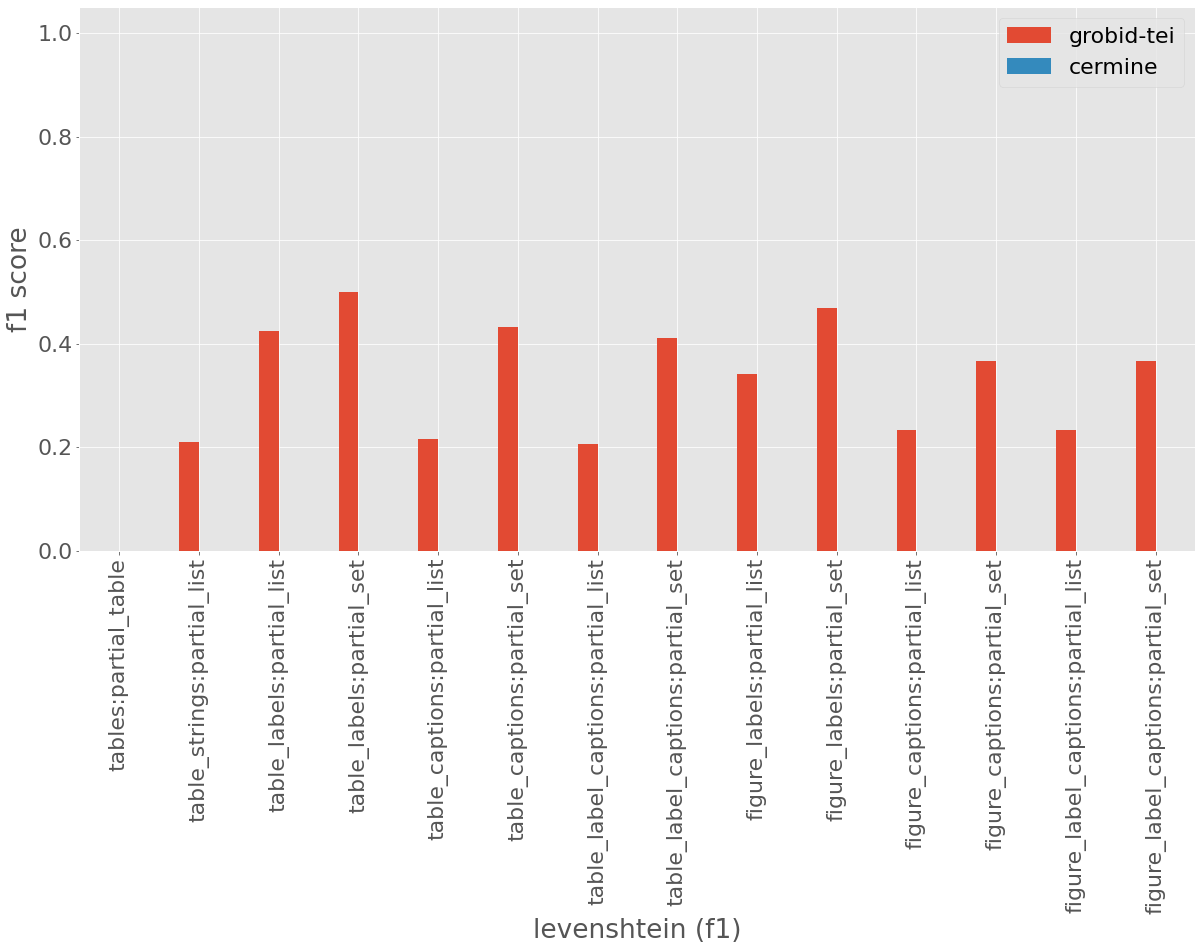

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
title:string,0.600000,0.700000,title,string,exact
first_author_full_name:string,0.600000,0.400000,first_author_full_name,string,exact
author_full_names:partial_set,0.491803,0.417582,author_full_names,partial_set,exact
abstract:string,0.117647,0.250000,abstract,string,exact
section_titles:partial_list,0.493506,0.195402,section_titles,partial_list,exact
section_titles:partial_set,0.794702,0.568047,section_titles,partial_set,exact
section_titles:partial_ulist,0.792208,0.563218,section_titles,partial_ulist,exact
affiliation_strings:partial_set,0.085106,0.037736,affiliation_strings,partial_set,exact
affiliation_institution:partial_set,0.243902,0.188679,affiliation_institution,partial_set,exact
mean,0.468764,0.368963,,,


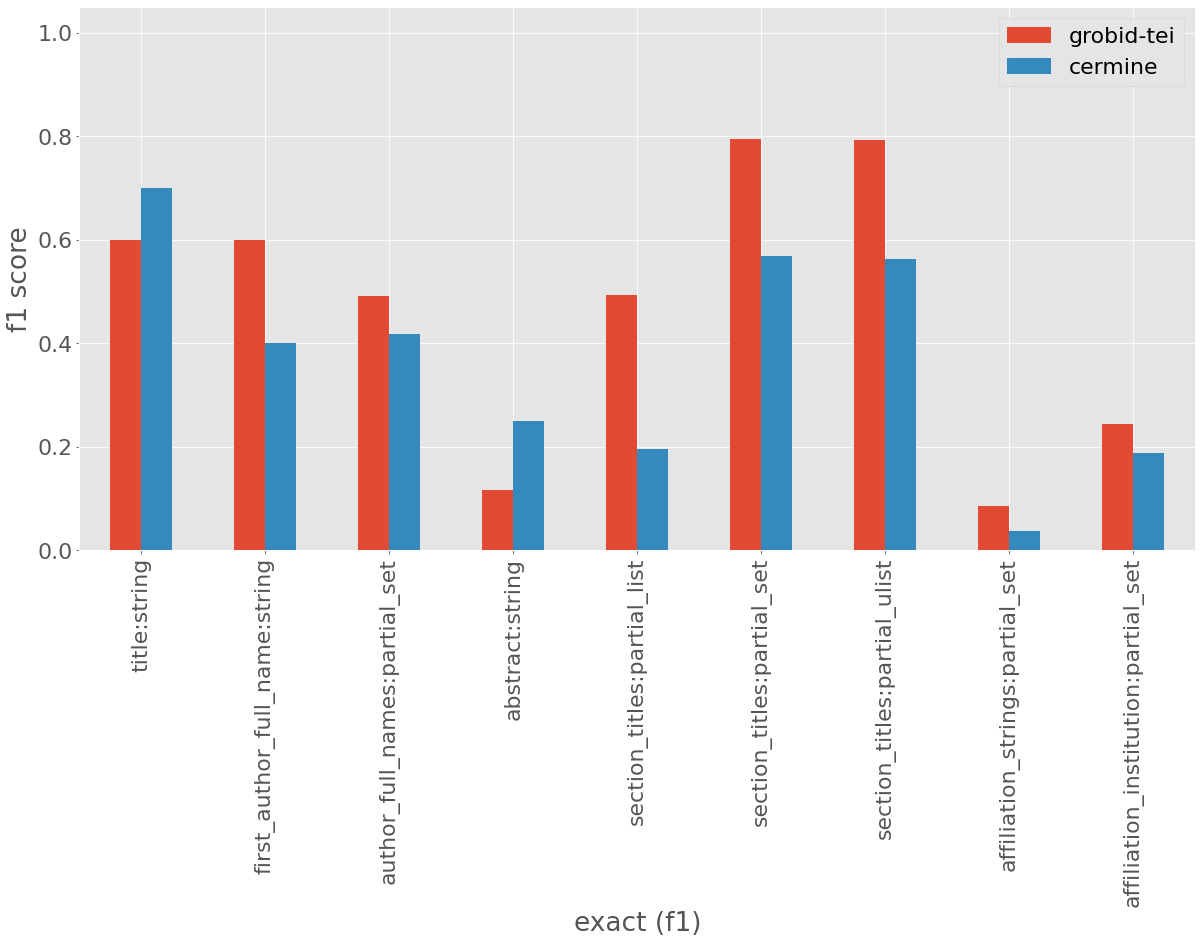

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
first_reference_text:string,0.000000,0.000000,first_reference_text,string,exact
first_reference_fields:list,0.000000,0.000000,first_reference_fields,list,exact
first_reference_author_surnames:list,0.400000,0.500000,first_reference_author_surnames,list,exact
first_reference_author_given_names:list,0.000000,0.200000,first_reference_author_given_names,list,exact
first_reference_author_full_names:list,0.000000,0.200000,first_reference_author_full_names,list,exact
first_reference_title:string,0.769231,1.000000,first_reference_title,string,exact
first_reference_year:string,0.500000,0.700000,first_reference_year,string,exact
first_reference_source:string,0.421053,0.600000,first_reference_source,string,exact
first_reference_volume:string,0.555556,0.750000,first_reference_volume,string,exact
first_reference_fpage:string,0.555556,0.750000,first_reference_fpage,string,exact


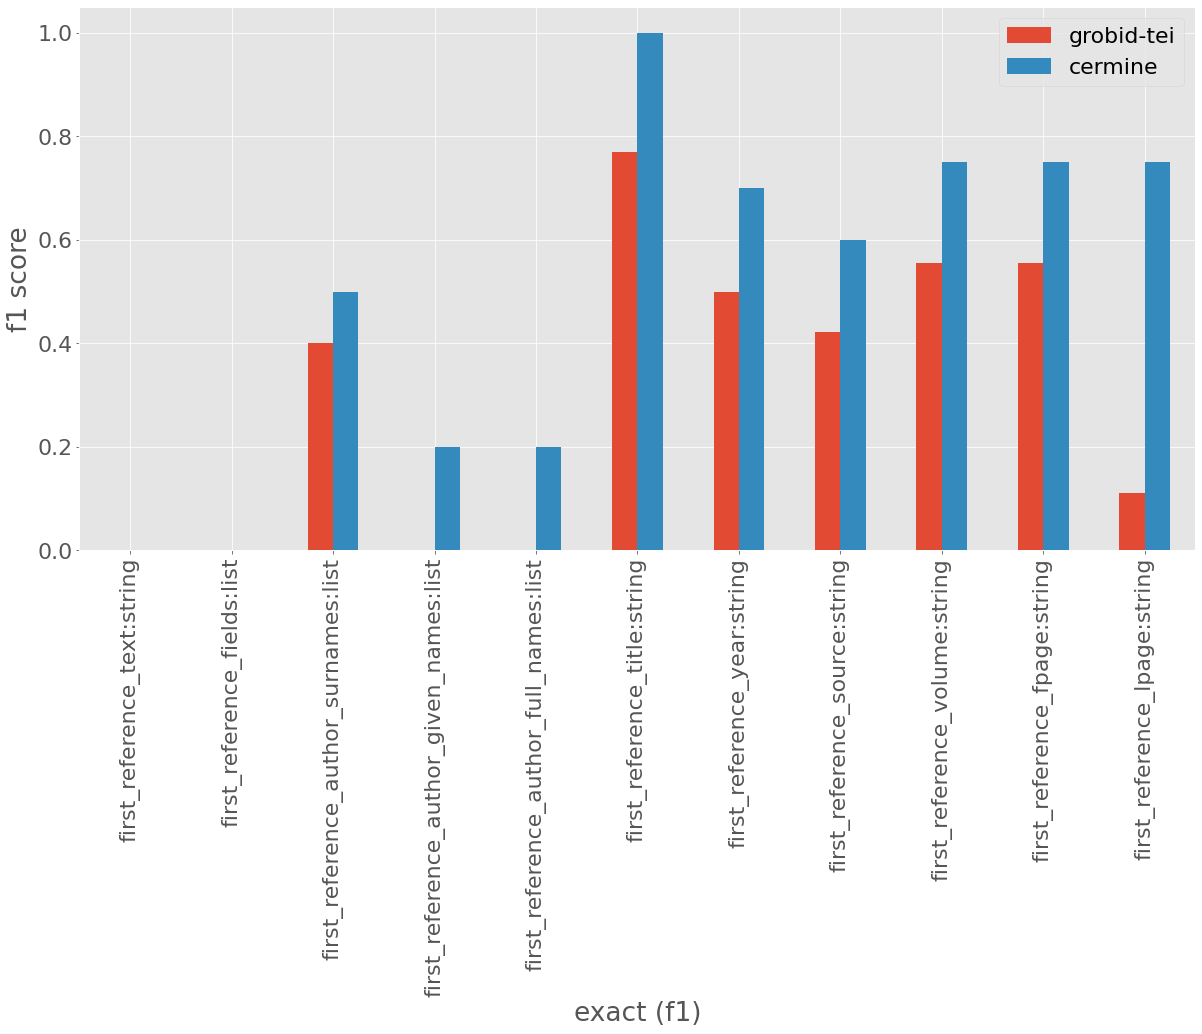

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
reference_text:partial_list,0.000000,0.000000,reference_text,partial_list,exact
reference_text:partial_set,0.000000,0.000000,reference_text,partial_set,exact
reference_text:partial_ulist,0.000000,0.000000,reference_text,partial_ulist,exact
reference_fields:partial_list,0.036649,0.044818,reference_fields,partial_list,exact
reference_fields:partial_ulist,0.047120,0.044818,reference_fields,partial_ulist,exact
reference_author_surnames:partial_list,0.209945,0.237960,reference_author_surnames,partial_list,exact
reference_author_surnames:partial_set,0.281609,0.231884,reference_author_surnames,partial_set,exact
reference_author_surnames:partial_ulist,0.317549,0.260623,reference_author_surnames,partial_ulist,exact
reference_author_given_names:partial_list,0.049587,0.190202,reference_author_given_names,partial_list,exact
reference_author_given_names:partial_set,0.092486,0.201183,reference_author_given_names,partial_set,exact


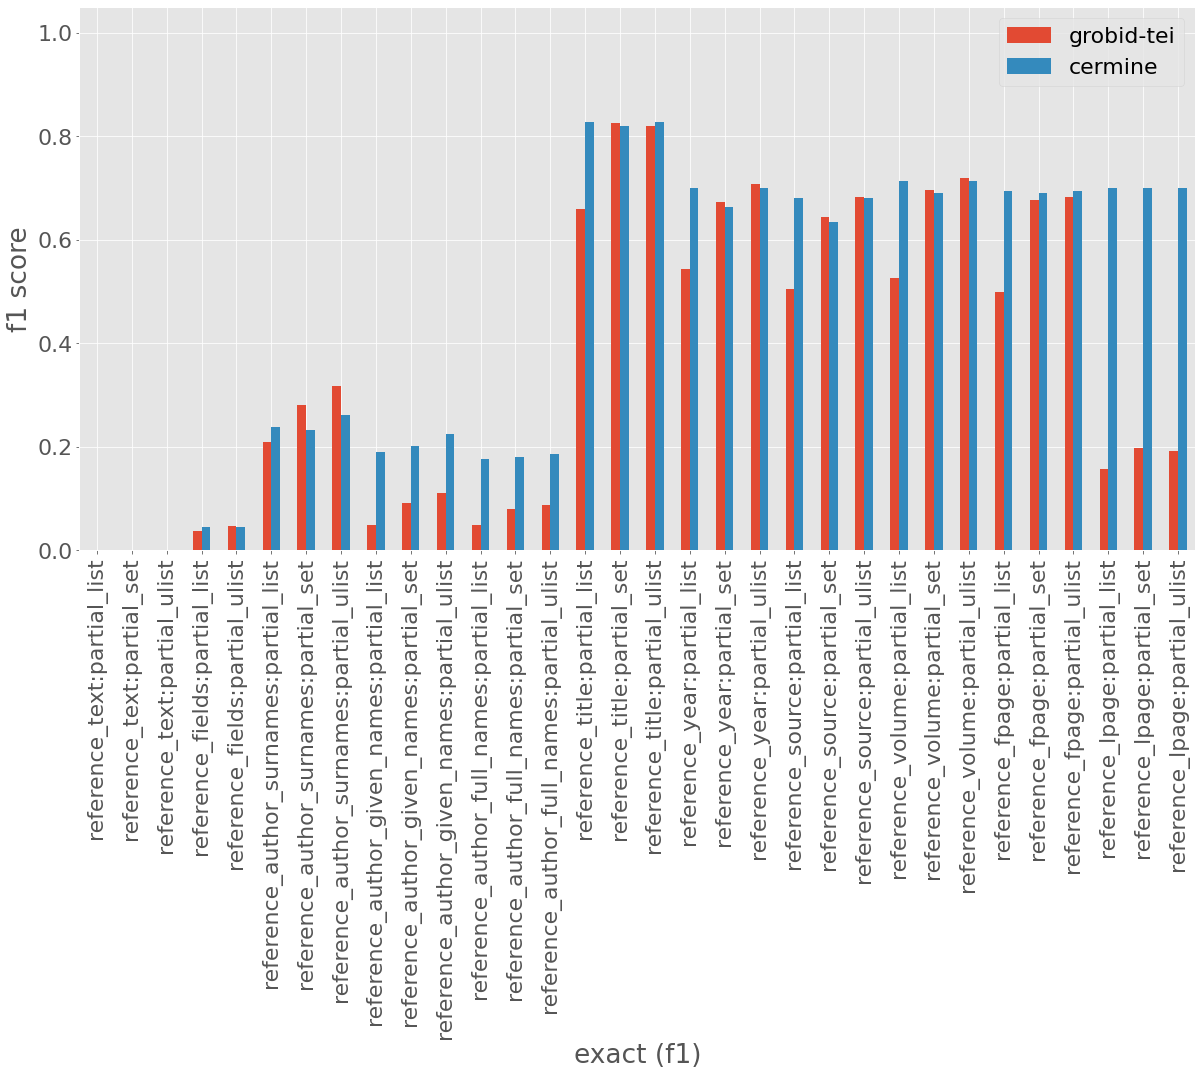

,grobid-tei,cermine,field_name,scoring_type,evaluation_method
tables:partial_table,0.000000,0.000000,tables,partial_table,exact
table_strings:partial_list,0.000000,0.000000,table_strings,partial_list,exact
table_labels:partial_list,0.060606,0.000000,table_labels,partial_list,exact
table_labels:partial_set,0.375000,0.000000,table_labels,partial_set,exact
table_captions:partial_list,0.162162,0.000000,table_captions,partial_list,exact
table_captions:partial_set,0.324324,0.000000,table_captions,partial_set,exact
table_label_captions:partial_list,0.051282,0.000000,table_label_captions,partial_list,exact
table_label_captions:partial_set,0.205128,0.000000,table_label_captions,partial_set,exact
figure_labels:partial_list,0.000000,0.000000,figure_labels,partial_list,exact
figure_labels:partial_set,0.127660,0.000000,figure_labels,partial_set,exact


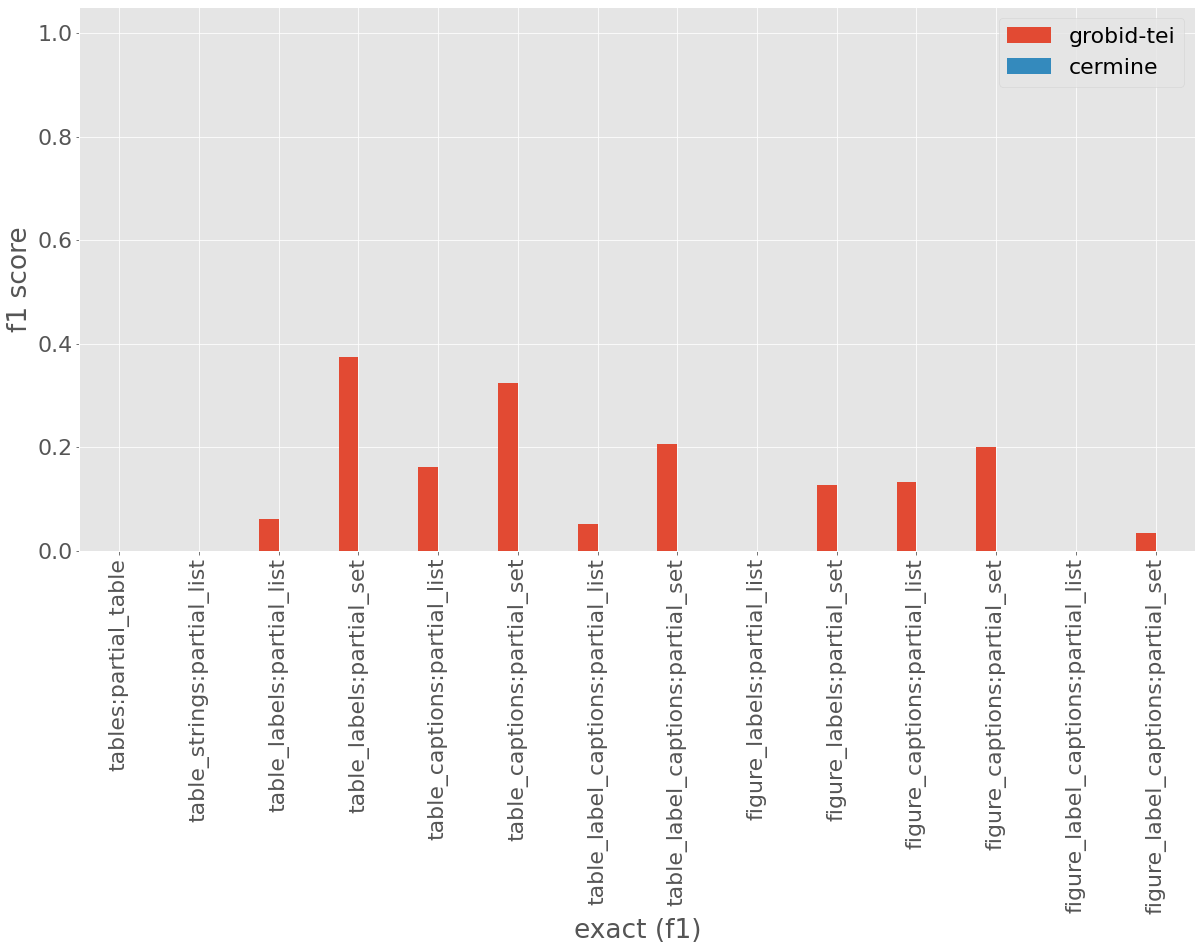

In [13]:
def short_name(full_name):
    return full_name.split(' ')[-1]


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s[s.apply(pd.np.isreal)].max()
    return ['font-weight: bold' if v else '' for v in is_max]


def to_sorted_field_name_scoring_types(
        field_name_scoring_types: List[str],
        field_names: List[str]) -> List[str]:
    available_field_name_scoring_types_map = {}
    for field_name_scoring_type in sorted(field_name_scoring_types):
        field_name = field_name_scoring_type.split(':')[0]
        available_field_name_scoring_types_map.setdefault(field_name, []).append(
            field_name_scoring_type
        )
    return [
        field_name_scoring_type
        for field_name in field_names
        for field_name_scoring_type in available_field_name_scoring_types_map.get(
            field_name,
            [field_name]
        )
    ]


def show_field_summaries(
        field_summaries_label_and_df, evaluation_method, score_name, field_names,
        table_id):
    def filter_df(df):
        return df[
            (df['evaluation_method'] == evaluation_method) &
            (df['field_name'].isin(field_names))
        ]

    def convert_df(df):
        return df.set_index('field_name_scoring_type')[score_name]

    short_field_summaries_label_and_df = [(short_name(k), df) for k, df in field_summaries_label_and_df]
    field_summaries_df_by_label = dict(short_field_summaries_label_and_df)
    labels = [k for k, _ in short_field_summaries_label_and_df]
    filtered_df_map = {k: filter_df(field_summaries_df_by_label[k]) for k in labels}
    
    field_details_df = pd.concat(
        filtered_df_map.values()
    )[['field_name', 'scoring_type', 'field_name_scoring_type', 'evaluation_method']].groupby(
        'field_name_scoring_type'
    ).agg(lambda l: ', '.join(set(l)))

    field_summary_df = pd.DataFrame({
        k: convert_df(filtered_df_map[k])
        for k in labels
    })[[short_name(k) for k, _ in field_summaries_label_and_df]]
    field_summary_df = field_summary_df.reindex(to_sorted_field_name_scoring_types(
        field_summary_df.index, field_names
    ))

    field_summary_table_df = field_summary_df.merge(field_details_df, left_index=True, right_index=True)
    field_summary_table_df = pd.concat([
        field_summary_table_df,
        field_summary_table_df[labels].mean().to_frame('mean').T
    ], sort=False).fillna('')
    
    max_document_count = max(
        df['document_count'].max() for df in filtered_df_map.values()
    )
    if max_document_count < 100:
        printmd('**Note:** sample size of **%d** is too small to provide a meaningful insight' % max_document_count)
    printmd('%s (max: %d)' % (', '.join([
        '%s: #%s' % (short_name(k), list(set(filter_df(df)['document_count']))[0])
        for k, df in field_summaries_label_and_df
    ]), max_document_count))

    warnings.filterwarnings('ignore')
    display(HTML(
        field_summary_table_df.style
        .set_uuid(table_id)
        .apply(highlight_max, axis=1)
        .render()
    ))
    warnings.filterwarnings('default')

    ax = field_summary_df.plot.bar(label='f1')
    plt.xlabel('%s (%s)' % (evaluation_method, score_name))
    plt.ylabel('f1 score')
    plt.ylim([0.0, 1.05])
    plt.show()


all_field_summaries_label_and_df = [
    (name, summary_df_map[name] if name else None)
    for name in all_result_names
]

for evaluation_method in evaluation_methods:
    for prefix in distinct_dataset_names:
        for field_set_name, field_names in field_set_field_names:
            printmd('## %s (%s - %s)' % (prefix, evaluation_method, field_set_name))
            show_field_summaries(
                [
                    (name, df)
                    for name, df in all_field_summaries_label_and_df
                    if name.startswith(prefix)
                ],
                evaluation_method=evaluation_method,
                score_name='f1',
                field_names=field_names,
                table_id='%s-%s-summary' % (prefix, evaluation_method)
            )